# Exploratory Data Analysis Notebook

### Description



### Files
1. 
2.
3.

### Evaluation

Evaluation Metric Template

Submission File
For each id in the test set, you must predict a probability a failure. The file should contain a header and have the following format:

- id,failure
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

### Important Points
- Different prototypes tested for product failures
- Given product attributes and measurement values, so only 2 types of attributes
- The simulated test uses loading
- You must predict individual product failures of new new codes with their lab test results

## Package Importing

In [2]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import seaborn as sns

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [3]:
import geopandas as gpd

## Data Importing

In [70]:
# specify name of file
#dataset_name = 'airview_dublincity_measurements_ugm3'
dataset_name = 'airview_dublincity_measurements_ugm3_csv'

folder_path = f'../data/raw/{dataset_name}'
shapefile_path = f'{folder_path}/AirView_DublinCity_Measurements_ugm3.csv'

In [71]:
# read in shapefile
df = pd.read_csv(shapefile_path, nrows = 100000)

<AxesSubplot: >

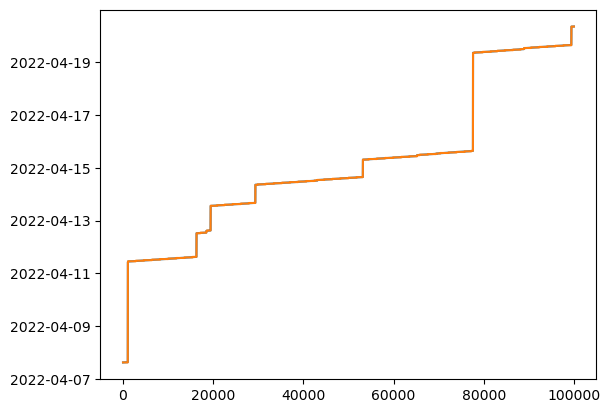

In [72]:
df.gps_timestamp = pd.to_datetime(df.gps_timestamp)
df.gps_timestamp.plot()

time_chunk = "30min"
df.gps_timestamp = df.gps_timestamp.round(time_chunk)
df.gps_timestamp.plot()

In [43]:
df.dtypes

gps_timestamp    datetime64[ns, UTC]
latitude                     float64
longitude                    float64
NO_ugm3                      float64
NO2_ugm3                     float64
O3_ugm3                      float64
CO_mgm3                      float64
CO2_mgm3                     float64
PMch1_perL                     int64
PMch2_perL                     int64
PMch3_perL                     int64
PMch4_perL                     int64
PMch5_perL                     int64
PMch6_perL                     int64
PM25_ugm3                    float64
dtype: object

<AxesSubplot: >

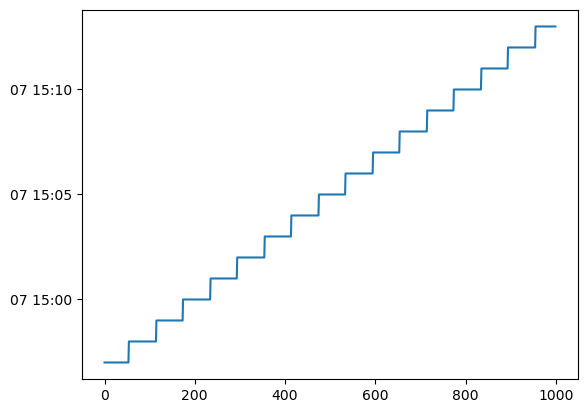

## Dataset Summaries and Heads

In [3]:
print("Number of rows in train data:    \t",train_data.shape[0])
print("Number of columns in train data: \t",train_data.shape[1])
print("\nNumber of rows in test data:     \t",test_data.shape[0])
print("Number of columns in test data:  \t",test_data.shape[1])
print("\nNumber of rows in sample data:   \t",sample.shape[0])
print("Number of column in sample data: \t",sample.shape[1])

Number of rows in train data:    	 26570
Number of columns in train data: 	 26

Number of rows in test data:     	 20775
Number of columns in test data:  	 25

Number of rows in sample data:   	 20775
Number of column in sample data: 	 2


In [4]:
# check datatypes of columns
print(train_data.dtypes.value_counts())

float64    16
int64       7
object      3
dtype: int64


In [5]:
# save names of categorical columns
numeric_cols = train_data.dtypes[train_data.dtypes != "object"].index
cat_cols = train_data.dtypes[train_data.dtypes == "object"].index

# view cardinalitites of categorical columns
print('non-numeric column categories based on data from ', train_data.shape[0],'rows')

cat_name = []
nunique_vals = []
for i in cat_cols:
    cat_name.append(i)
    nunique_vals.append(train_data.loc[:,i].nunique())

cat_counts = pd.Series(data=nunique_vals,index=cat_name).sort_values(ascending = False)

fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y = cat_counts.index, x = cat_counts, orient='h')

non-numeric column categories from 26570 rows
	 product_code 	 5
	 attribute_0 	 2
	 attribute_1 	 3


In [6]:
train_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [7]:
test_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [8]:
sample.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [9]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
measurement_17,2284,8.596161
measurement_16,2110,7.941287
measurement_15,2009,7.561159
measurement_14,1874,7.053067
measurement_13,1774,6.676703
measurement_12,1601,6.025593
measurement_11,1468,5.525028
measurement_10,1300,4.892736
measurement_9,1227,4.617990
measurement_8,1048,3.944298


<AxesSubplot:xlabel='failure', ylabel='count'>

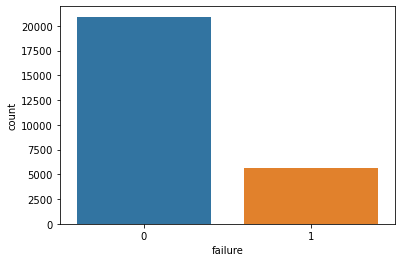

In [10]:
# checking target variable percentage
sns.countplot(x="failure", data=train_data)
#sns.countplot(x="failure", data=test_data)
#sns.countplot(x="failure", data=sample)

# this is a class imbalance problem

## Distributional drift and comparisons

In [11]:
train_data.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

each of the products could have very different behaviours and be from different populations. And so it may make sense to look at each on of these individually

## Static Profiling

In [12]:
# sample data if required if reports too big
train_sample = train_data.sample(10000)

# drop id column
train_sample.drop('id',axis = 1, inplace=True)

# drop index or else that will also be profiled
train_sample.reset_index(drop=True, inplace=True)

In [13]:
# create minimal report in reports
minimal_report = train_data.profile_report(title="Minimal Report",minimal=True)
minimal_report.to_file("../reports/pp_eda_minimal.html")
#minimal_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
# set of parameters to create customer report
train_data.profile_report(
    title="Custom Report",
    # create missing/null value diagrams
    # disable if no missing values
    missing_diagrams={
        "heatmap": True,
        "dendrogram": True,
        "bar": True,
        "matrix":True
    # create all correlation plots
    # the correlations and interactions come together
    # the correlations section dictates which corrs will be run
    # the interactions dicatates which variables
    },correlations={
        # strength and directional
        # continuous vars, linear, sensitive to outliers, normal dist
        "pearson": {"calculate": True},
        # strength and directional
        # categorical or quant, linear, no outliers
        "spearman": {"calculate": False},
        # 0-1
        # dependence of 2 vars.
        "kendall": {"calculate": True},
        # no direction, categorical, ordinal, interval
        # non-linear dependency
        # computationally expensive
        "phi_k": {"calculate": True}, # this one is one of the most intensive ones
        # compares 2 categorical vars
        # based on chi-squared test stat
        # sensitive to outlies
        "cramers": {"calculate": True}
    },interactions = {
        # this generates 2d scatter, this will cause crash if too many variables
        "continuous": False
        # comment continouous out and put in 
        # target var to see scatter between
        # only these values and all other
        # values
        #"targets": ['target']
    },html = {
        "style": {"theme":"flatly"}
    }
    
    
).to_file("../reports/pp_eda_custom.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning

Creation of data cleaning function to;
- Impute NULL Values
- Parse Multi-part string columns
- Drop columns
- Encode categorical variables
- Normalise or scale columns

In [15]:
def Preprocessing(df):
    
    df = pd.get_dummies(df) # convert all categorical variables to dummy variables
    
    df = df.dropna(
        # axis = 1 # default both axes, comment out for only 1 axis
    ) # remvoe all na rows or columns
    
    return df

train_data_cleaned = Preprocessing(train_data)

print("missing values present:",train_data_cleaned.isna().sum().sum())
print("categorical columns present:",train_data_cleaned.dtypes[train_data_cleaned.dtypes == "object"].count())



missing values present: 0
categorical columns present: 0


## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_cleaned.drop(['id','failure'], axis = 1), # X data excluding target variable and any irrelevant id columns
    train_data_cleaned.loc[:,'failure'],
    test_size = 0.2, # 0.2 is a good accepted starting point, with larger data this number can be decreased
    random_state = 42, # random seed, default 42
    shuffle = True # default true, check whether there is population drift over time in default order
)

print("Shape of X_train data:    \t",X_train.shape)
print("Shape of X_test data:    \t",X_test.shape)
print("Shape of y_train data:    \t",y_train.shape)
print("Shape of y_test data:    \t",y_test.shape)

Shape of X_train data:    	 (9746, 31)
Shape of X_test data:    	 (2437, 31)
Shape of y_train data:    	 (9746,)
Shape of y_test data:    	 (2437,)


### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
# help(LinearRegression)

In [18]:
# initialise new linear regression object model
model = LinearRegression()

In [19]:
# Fir regression model
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# predict values on test set
test_preds = model.predict(X_test)

In [ ]:
test_residuals = y_test - test_preds

# ideally this is normal
sns.scatterplot(x=y_test,y=test_residuals)
plt.axhline(y=0,color='r',ls='--')

In [ ]:
# these coeffients will be in different units
model.coef_

In [ ]:
from joblib import dump, load
dump(model,'../models/linear_regression_model.joblib')